In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction

This report presents my approach to the Kaggle competition "I'm Something of a Painter Myself," which challenges participants to generate art using Generative Adversarial Networks (GANs). This project aims to build a model that can produce visually compelling art pieces by learning from a dataset of artwork. This project offers a unique opportunity to explore the creative potential of machine learning and experiment with neural network architectures designed explicitly for generative tasks.

## Problem Overview

The primary challenge is to generate high-quality images that capture the characteristics of artwork. This task requires a model to learn complex data distributions and generate new samples that resemble real images. I have decided to use GANs, as they are particularly suited for this kind of task due to their adversarial training mechanism, which often produces realistic images.

## Data Overview

The dataset for this competition is structured to support the generation of Monet-style art. It contains four primary directories:

- **monet_jpg**: 300 Monet paintings in JPEG format, each sized 256x256 pixels.
- **monet_tfrec**: The same 300 Monet paintings in TFRecord format.
- **photo_jpg**: 7,028 photos in JPEG format, each also sized 256x256 pixels.
- **photo_tfrec**: The same 7,028 photos in TFRecord format.

### Purpose of Each Directory

The **monet** directories contain a curated selection of Monet paintings, which serve as the primary training data for the model to learn Monet's distinctive style. The **photo** directories contain real-world photos, which will be transformed to imitate Monet's artistic style. This transformation is the main objective of the competition.

# Exploratory Data Analysis (EDA)

In this section, I will inspect, visualize, and clean the dataset to better understand its structure and characteristics. 
I will explore the following:

1. **Data Inspection**: Display a few samples of Monet paintings and photos to understand the visual differences.
2. **Data Visualization**: Use histograms and other visualizations to observe the distribution of pixel values, color channels, and any notable patterns.
3. **Data Cleaning**: Check for any inconsistencies or missing data that might affect the model training process.

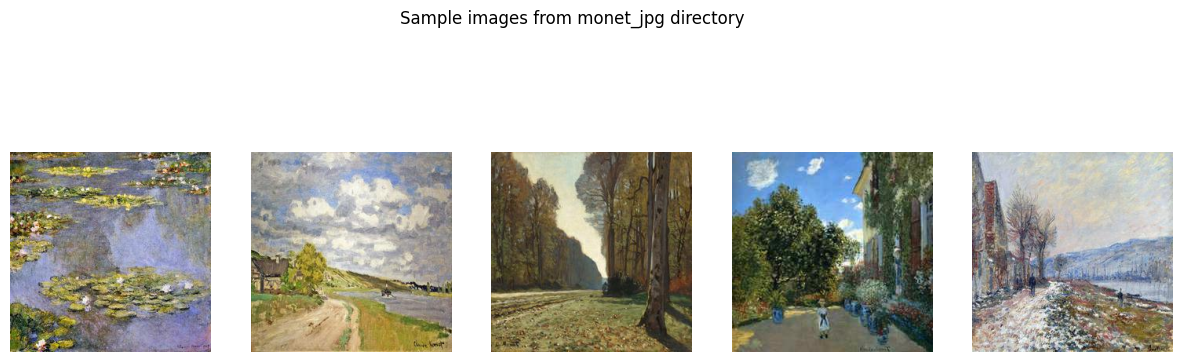

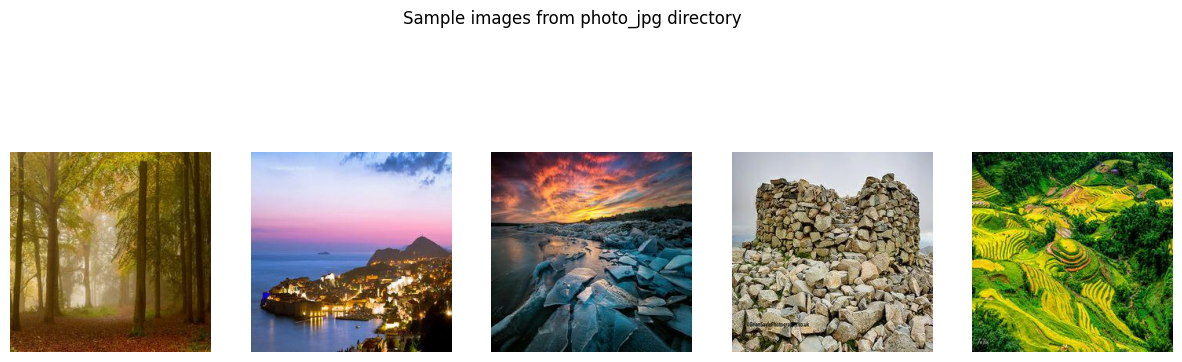

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Directory paths
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
photo_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Function to display sample images
def display_sample_images(path, sample_size=5):
    # Get a list of images in the directory (limit to sample_size)
    images = os.listdir(path)[:sample_size]
    plt.figure(figsize=(15, 5))
    
    for i, image_name in enumerate(images):
        # Read and display each image
        img = plt.imread(os.path.join(path, image_name))
        plt.subplot(1, sample_size, i + 1)
        plt.imshow(img)
        plt.axis("off")
    
    # Set a title for the image samples
    plt.suptitle(f"Sample images from {os.path.basename(path)} directory")
    plt.show()

# Display sample images from the Monet directory
display_sample_images(monet_path)

# Display sample images from the photo directory
display_sample_images(photo_path)


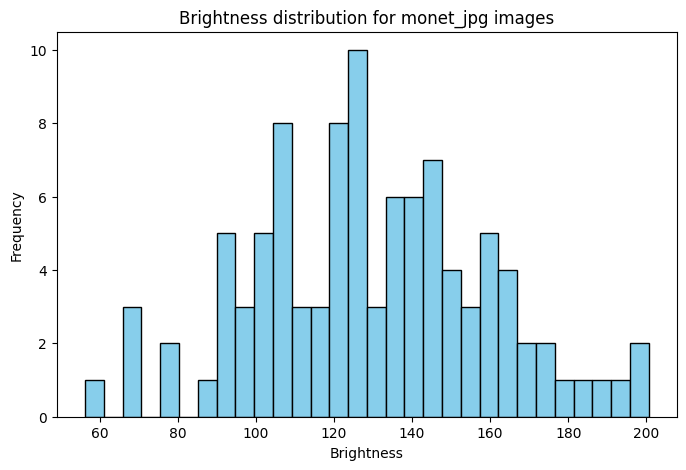

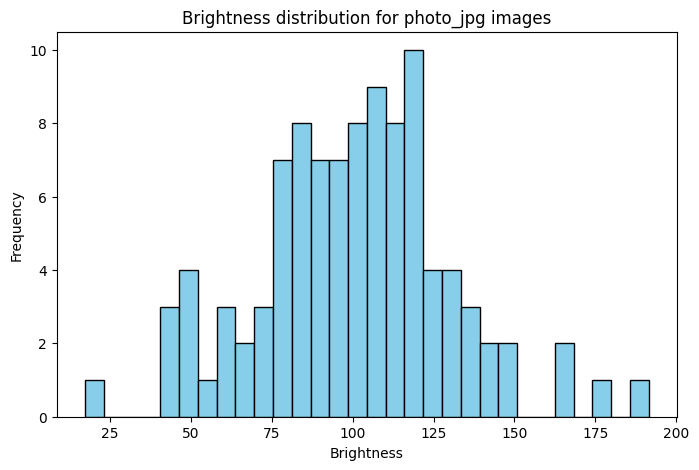

In [3]:
import numpy as np

# Function to plot brightness distribution for a set of images
def plot_brightness_distribution(path, sample_size=100):
    # Get a list of images in the directory (limit to sample_size)
    images = os.listdir(path)[:sample_size]
    brightness_values = []

    for image_name in images:
        # Read each image
        img = plt.imread(os.path.join(path, image_name))
        # Convert the image to grayscale to analyze brightness
        grayscale_img = np.mean(img, axis=2)  # Average over color channels
        # Calculate the average brightness of the image
        brightness = grayscale_img.mean()
        brightness_values.append(brightness)

    # Plot histogram of brightness values
    plt.figure(figsize=(8, 5))
    plt.hist(brightness_values, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Brightness distribution for {os.path.basename(path)} images")
    plt.xlabel("Brightness")
    plt.ylabel("Frequency")
    plt.show()

# Plot brightness distribution for Monet images
plot_brightness_distribution(monet_path)

# Plot brightness distribution for photo images
plot_brightness_distribution(photo_path)

## Brightness Distribution Analysis

To understand the brightness characteristics of Monet paintings and real-world photos, I calculated the average brightness for each image in both datasets and plotted histograms to visualize the distributions.

- **Monet Paintings**: The brightness distribution of Monet paintings is relatively wide, with a peak of around 120. This suggests that Monet's artwork contains various brightness levels, often capturing the subtle nuances of light in his style.

- **Photos**: In comparison, the brightness distribution of photos is more concentrated, with a peak around 100-125. This indicates that photos tend to have a more consistent brightness, likely due to the uniform lighting conditions in photographic images.

These differences in brightness distribution highlight a potential challenge in transforming photos to the Monet style. The model may need to account for the broader range of brightness found in Monet paintings to generate realistic results.

The next steps will involve analyzing the color channels (RGB) to further understand the color characteristics of each dataset.

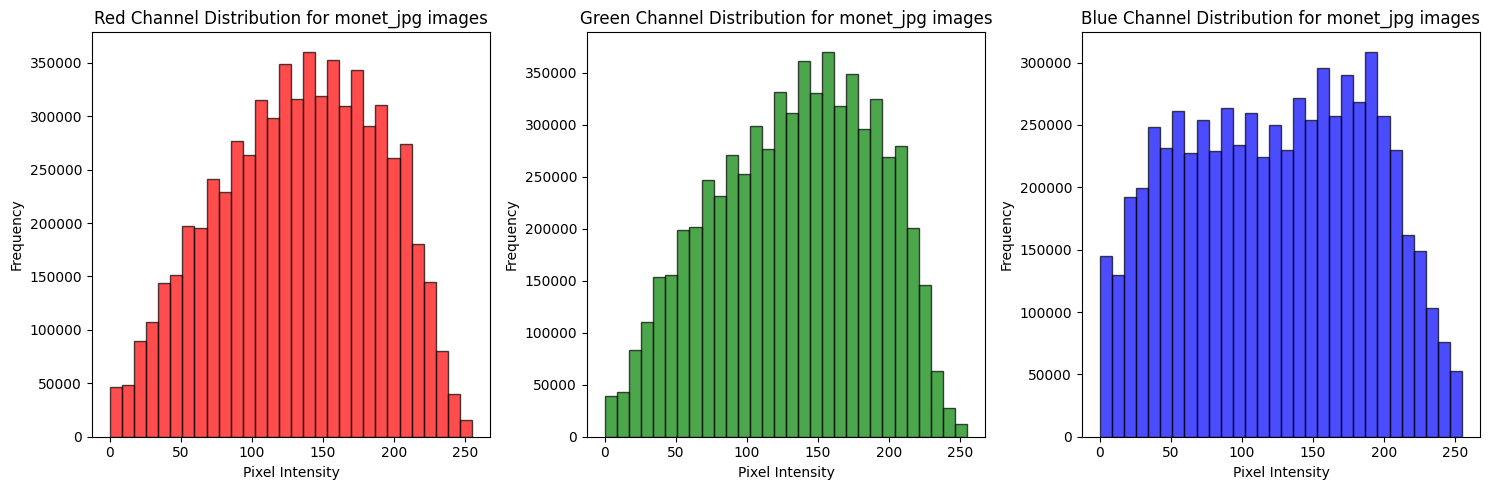

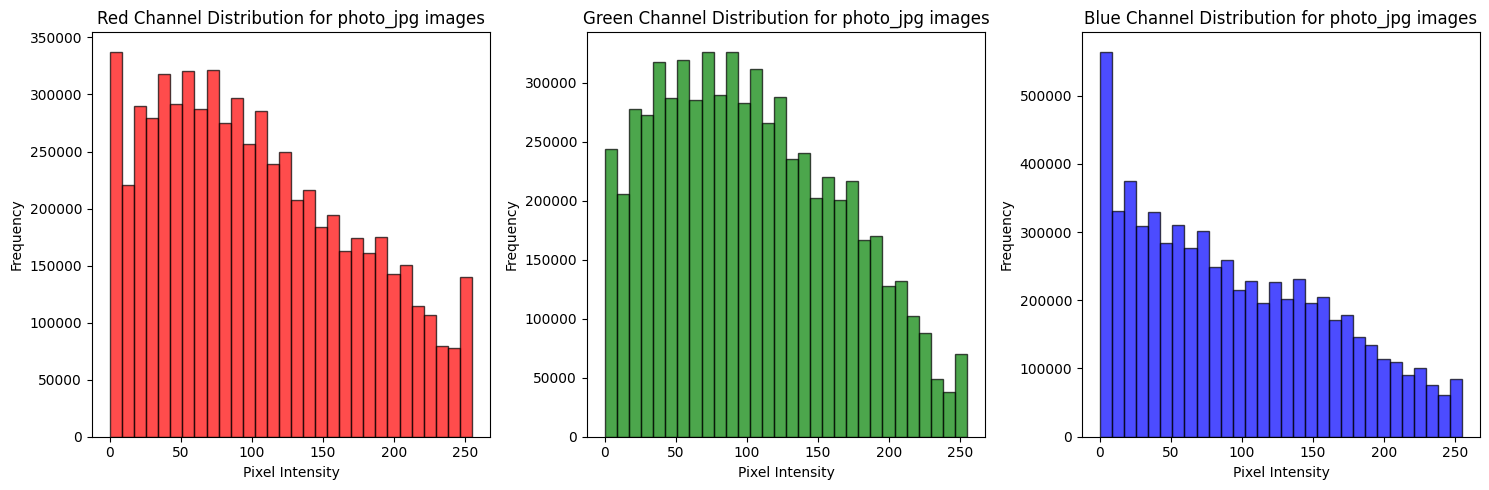

In [4]:
# Function to plot RGB channel distributions for a set of images
def plot_rgb_distribution(path, sample_size=100):
    # Get a list of images in the directory (limit to sample_size)
    images = os.listdir(path)[:sample_size]
    red_values = []
    green_values = []
    blue_values = []

    for image_name in images:
        # Read each image
        img = plt.imread(os.path.join(path, image_name))
        # Separate color channels
        red_values.extend(img[:, :, 0].flatten())
        green_values.extend(img[:, :, 1].flatten())
        blue_values.extend(img[:, :, 2].flatten())

    # Plot histograms for each color channel
    plt.figure(figsize=(15, 5))

    # Red channel histogram
    plt.subplot(1, 3, 1)
    plt.hist(red_values, bins=30, color="red", edgecolor="black", alpha=0.7)
    plt.title(f"Red Channel Distribution for {os.path.basename(path)} images")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    # Green channel histogram
    plt.subplot(1, 3, 2)
    plt.hist(green_values, bins=30, color="green", edgecolor="black", alpha=0.7)
    plt.title(f"Green Channel Distribution for {os.path.basename(path)} images")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    # Blue channel histogram
    plt.subplot(1, 3, 3)
    plt.hist(blue_values, bins=30, color="blue", edgecolor="black", alpha=0.7)
    plt.title(f"Blue Channel Distribution for {os.path.basename(path)} images")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Plot RGB distribution for Monet images
plot_rgb_distribution(monet_path)

# Plot RGB distribution for photo images
plot_rgb_distribution(photo_path)

## RGB Channel Distribution Analysis

To better understand the color characteristics, I analyzed the distribution of pixel intensities for each RGB channel (Red, Green, and Blue). The histograms above display the distribution of each color channel.

### Monet

- **Red Channel**: The red channel shows a relatively balanced distribution, with a peak around the mid-intensity range (100-150). This suggests that Monet paintings often contain warm tones but also include a variety of shades, creating depth in the red hues.

- **Green Channel**: The green channel distribution is also relatively broad, with a peak in the mid-intensity range (around 100-150), similar to the red channel. This indicates that green tones are frequently used, possibly to depict natural elements like trees or landscapes.

- **Blue Channel**: The blue channel exhibits a unique pattern, with a broader distribution that leans slightly toward higher intensities. This suggests that Monet’s paintings utilize cooler tones in certain areas, adding balance and contrast to the overall color palette.

These color distribution patterns reflect the typical color balance in Monet's style, which mixes warm and cool tones to achieve a harmonious and vibrant look.

### Photo

- **Red Channel**: The red channel shows a skewed distribution towards lower intensities, with a peak near 0-50. This indicates that photos generally contain less intense red hues compared to Monet paintings, which tend to have a more balanced red distribution. This may reflect natural color variations under different lighting conditions in real-world photos.

- **Green Channel**: The green channel also has a peak at lower intensities (around 50-100), although it is slightly more spread out than the red channel. This contrasts with the Monet paintings, where the green distribution is more balanced. The lower green intensities suggest that natural elements in photos might have less vibrant shades.

- **Blue Channel**: The blue channel has a strong skew towards lower intensities, with a peak around 0-50. This is a distinct contrast to Monet paintings, which show a broader blue distribution with higher intensities. This could be due to the predominance of cooler and subdued tones in natural photos.

Overall, the color distributions in photos are more concentrated at lower intensities across all channels compared to Monet paintings. This suggests that transforming photos into Monet-style artwork may require a color enhancement in all channels, especially in the blue and red ranges, to capture the vibrant and balanced color palette characteristic of Monet's art.

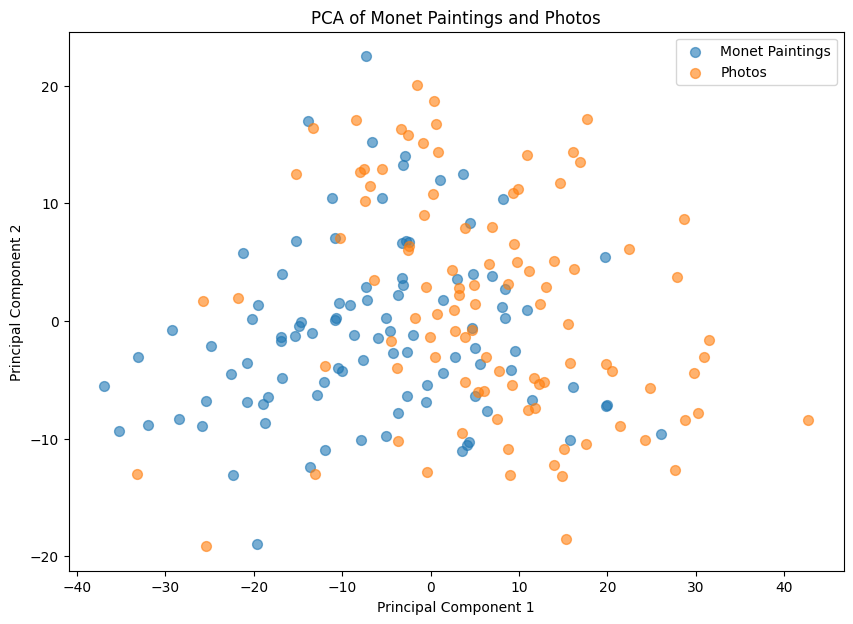

In [5]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import os

# Load and preprocess images for PCA
def load_images_for_pca(path, sample_size=100, img_size=(64, 64)):
    images = os.listdir(path)[:sample_size]
    image_data = []

    for image_name in images:
        # Read and resize each image to a smaller size for PCA
        img = plt.imread(os.path.join(path, image_name))
        img_resized = np.array(img)
        if img_resized.shape != img_size:
            img_resized = tf.image.resize(img, img_size).numpy()
        img_resized = img_resized / 255.0  # Normalize pixel values
        img_flat = img_resized.flatten()    # Flatten the image
        image_data.append(img_flat)

    return np.array(image_data)

# Load images from both directories
monet_data = load_images_for_pca(monet_path)
photo_data = load_images_for_pca(photo_path)

# Combine the data and create labels
all_data = np.vstack([monet_data, photo_data])
labels = np.array(['Monet'] * len(monet_data) + ['Photo'] * len(photo_data))

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_data)

# Plot PCA results
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[labels == 'Monet', 0], pca_result[labels == 'Monet', 1], 
            label="Monet Paintings", alpha=0.6, s=50)
plt.scatter(pca_result[labels == 'Photo', 0], pca_result[labels == 'Photo', 1], 
            label="Photos", alpha=0.6, s=50)
plt.title("PCA of Monet Paintings and Photos")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

## PCA Analysis of Monet Paintings and Photos

To explore the overall patterns in Monet paintings and photos, I applied Principal Component Analysis (PCA) to reduce the dimensionality of the image data. I plotted the results in a 2D space.

The scatter plot above shows the distribution of Monet paintings and photos along the first two principal components:

- **Monet Paintings (blue)** and **Photos (orange)** are scattered throughout the space without forming clearly separated clusters. This suggests that the overall features of Monet paintings and photos are not drastically different in terms of pixel intensities when reduced to these principal components.

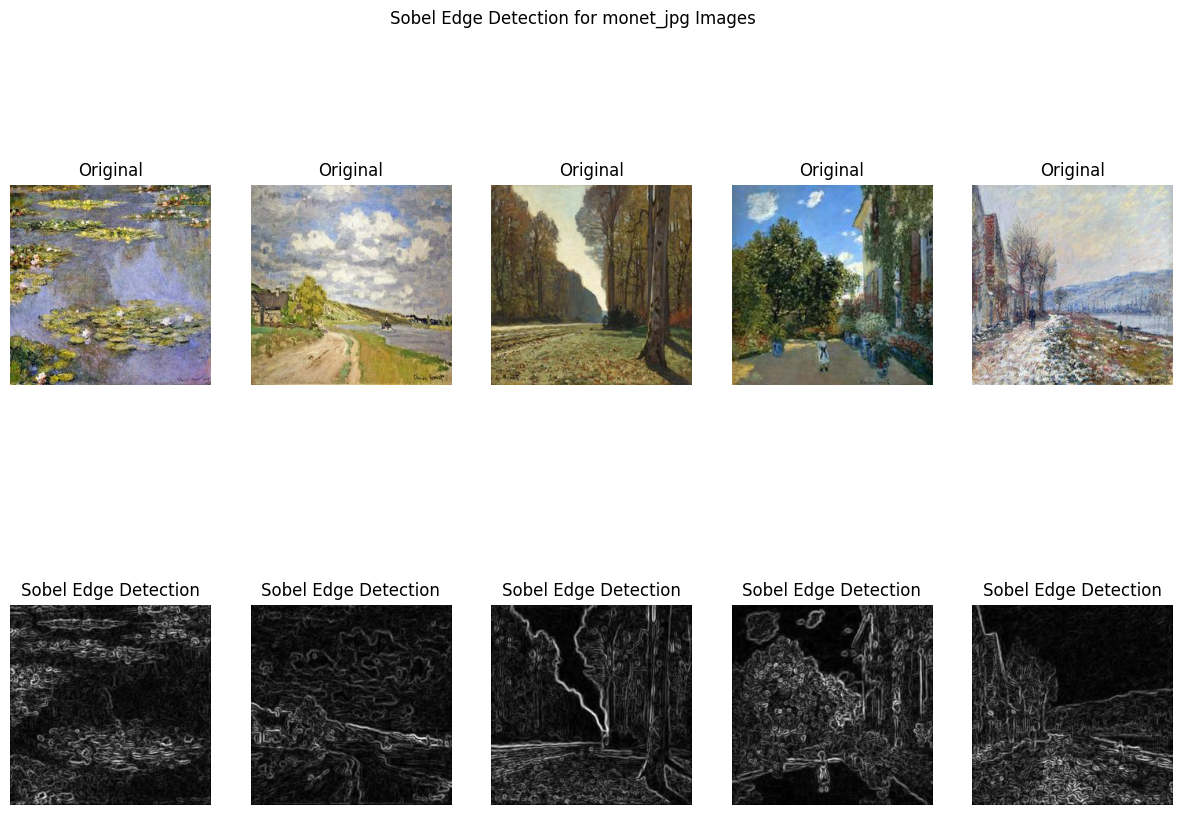

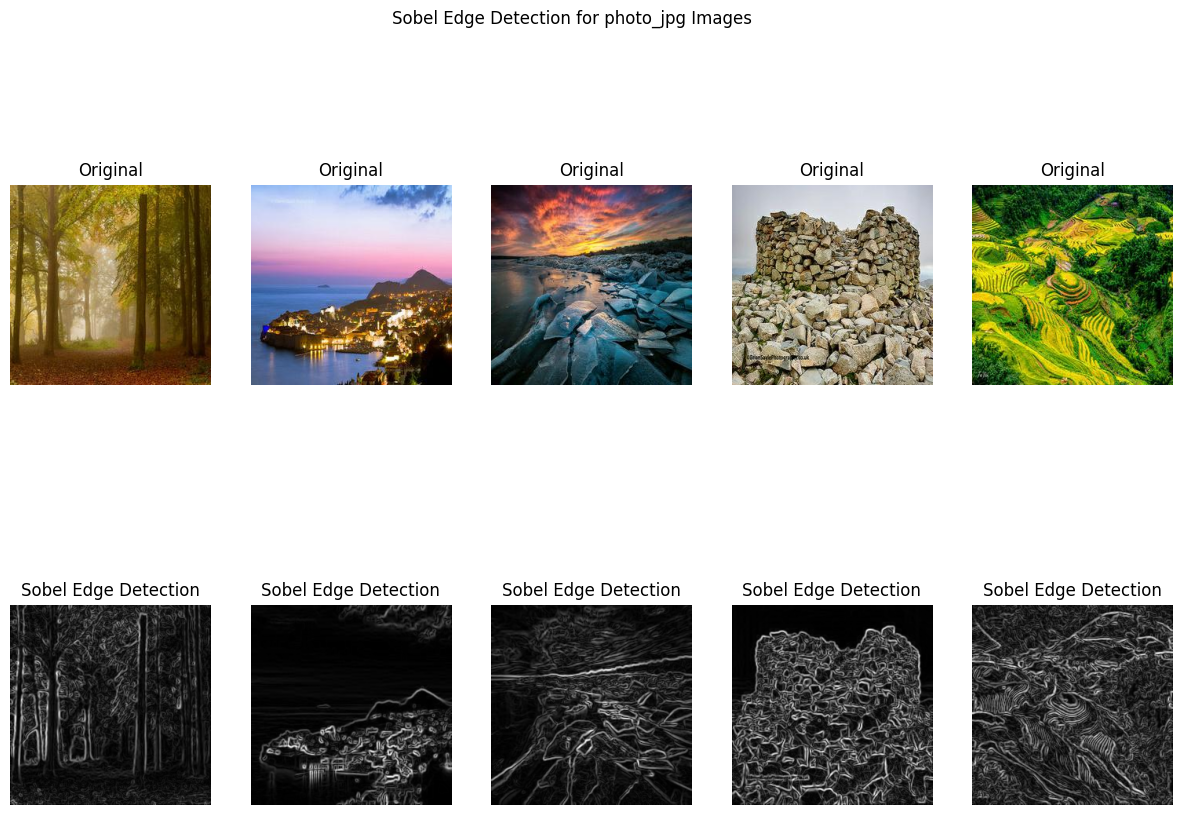

In [6]:
import cv2
import matplotlib.pyplot as plt

# Function to apply Sobel edge detection and display the result
def sobel_edge_detection(path, sample_size=5):
    images = os.listdir(path)[:sample_size]
    plt.figure(figsize=(15, 10))
    
    for i, image_name in enumerate(images):
        # Read each image in grayscale
        img = plt.imread(os.path.join(path, image_name))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Apply Sobel edge detection
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  # X direction
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  # Y direction
        sobel = cv2.magnitude(sobelx, sobely)  # Combine X and Y

        # Display the original and edge-detected images side by side
        plt.subplot(2, sample_size, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Original")

        plt.subplot(2, sample_size, i + 1 + sample_size)
        plt.imshow(sobel, cmap='gray')
        plt.axis("off")
        plt.title("Sobel Edge Detection")
    
    plt.suptitle(f"Sobel Edge Detection for {os.path.basename(path)} Images")
    plt.show()

# Apply Sobel edge detection to Monet images
sobel_edge_detection(monet_path)

# Apply Sobel edge detection to photo images
sobel_edge_detection(photo_path)

# Model Architecture

For this project, I used a **CycleGAN** architecture to transform real-world photos into Monet-style paintings. CycleGANs are a type of Generative Adversarial Network (GAN) specifically designed for unpaired image-to-image translation, which is well-suited for this task where direct one-to-one image pairs between photos and Monet paintings are unavailable. The CycleGAN model consists of two **Generator** networks and two **Discriminator** networks, which work in an adversarial setting to achieve realistic style transfer.

### Why CycleGAN?

CycleGAN is particularly effective for tasks that require style transfer between domains without paired data due to its unique structure:
- **Unpaired Data Compatibility**: CycleGAN allows for image-to-image translation using unpaired datasets, making it ideal for this project where we do not have matching pairs of photos and Monet paintings.
- **Cycle Consistency Loss**: This loss function ensures that an image is transformed to the other domain and then returned to the original domain to retain its core content and structure. This helps preserve the important features of the photos while applying Monet's artistic style.
- **Identity Loss**: This loss encourages the model to leave images unchanged when they are already in the target domain, which improves the stylistic consistency and reduces artifacts.

## Model Components and Design Choices

1. **Generator Network**:
   - The generator network uses convolutional layers with residual blocks to model complex textures and color transformations. The residual blocks enable the model to capture the organic brushstrokes and soft transitions characteristic of Monet's style.
   - **Layer Normalization** layers maintain consistent color balance across the generated images, aligning with Monet's vibrant and balanced color palette.
   - **Upsampling Layers** are included to ensure high-resolution output images that capture the detail and texture present in Monet's artwork.

2. **Discriminator Network**:
   - The discriminator network consists of convolutional layers distinguishing between real Monet paintings and generated images. It provides feedback to the generator, helping it create images that closely resemble the Monet style in terms of texture, color, and overall composition.

### Hyperparameter Tuning

Several key hyperparameters were tuned to optimize the model's performance:
- **Learning Rate**: Set to 0.0002 for both generators and discriminators, which is a common setting for GANs to prevent instability in training.
- **Loss Weights**: The cycle consistency loss and identity loss weights were set to 10 and 5, respectively. These values help balance the model's ability to transform styles while retaining essential content.
- **Batch Size**: Initially set to 32, but reduced to 8 due to memory constraints. This adjustment allowed the model to run efficiently within available resources and improved training stability.

#### Comparison with Other Architectures

- **Pix2Pix**: This architecture is another GAN-based model for image-to-image translation but requires paired training data, which is not feasible for this project due to the lack of direct mappings between photos and Monet paintings.
- **Variant Architectures within CycleGAN**: Alternative configurations, such as modifying the number of residual blocks or experimenting with Batch Normalization, were considered. However, the chosen configuration of 6 residual blocks with Layer Normalization provided a good balance between quality and computational efficiency for this task.

In summary, CycleGAN was selected and configured to leverage unpaired data, maintain content consistency, and apply vibrant stylistic transformations in line with Monet's painting characteristics. 


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Generator
def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))
    
    # Downsampling layers
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = layers.ReLU()(x)
    
    # Residual blocks
    for _ in range(6):
        x = residual_block(x, 64)
    
    # Upsampling layers
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = layers.ReLU()(x)
    
    # Output layer
    outputs = layers.Conv2D(3, kernel_size=7, padding="same", activation="tanh")(x)
    
    return models.Model(inputs, outputs, name="Generator")

# Define a residual block
def residual_block(x, filters):
    res = x
    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.LayerNormalization()(x)  # Replace InstanceNormalization with LayerNormalization
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.LayerNormalization()(x)  # Replace InstanceNormalization with LayerNormalization
    return layers.add([res, x])

# Define the Discriminator
def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))
    
    # Convolutional layers
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)
    
    for filters in [128, 256, 512]:
        x = layers.Conv2D(filters, kernel_size=4, strides=2, padding="same")(x)
        x = layers.LayerNormalization()(x)  # Replace InstanceNormalization with LayerNormalization
        x = layers.LeakyReLU(0.2)(x)
    
    # Output layer
    outputs = layers.Conv2D(1, kernel_size=4, padding="same")(x)
    
    return models.Model(inputs, outputs, name="Discriminator")

# Instantiate the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Display the architecture summary
generator.summary()
discriminator.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,136 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ layer_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ re_lu[0][0],      │
│                     │ 64)               │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ layer_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ add[0][0],        │
│                     │ 64)               │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_5[0][0]  

 Total params: 522,819 (1.99 MB)

 Trainable params: 522,819 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (None, 64, 64, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_13          │ (None, 32, 32, 256)    │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_14          │ (None, 16, 16, 512)    │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,529 (10.55 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

### Training Process

To train the CycleGAN model, I defined a customized training process that optimizes the Generator and Discriminator networks simultaneously. Each training step consists of the following components:

1. **Forward Cycle**: 
   - The generator \(G\) converts a real-world photo to a Monet-style image.
   - The generator \(F\) then attempts to transform the Monet-style image back into the original photo.
   - This process ensures **cycle consistency**, as the output should closely match the original image.

2. **Backward Cycle**:
   - Similarly, a real Monet-style image is converted to a photo-like image by \(F\).
   - The generator \(G\) then reconverts the photo back to a Monet-style image.
   - This cycle further enforces consistency, helping the model retain important image features.

#### Loss Functions

The model optimizes the following loss functions in each step:

- **Adversarial Loss**: Ensures that each generator produces images that are indistinguishable from real images in the target domain, as judged by the corresponding discriminator.
- **Cycle Consistency Loss**: Enforces that an image, after being translated to the other domain and back, retains its original content and structure.
- **Identity Loss**: Ensures that if the input image is already in the target domain, the generator will leave it unchanged.

#### Training Steps

For each epoch, the following steps are performed:

1. **Update Discriminators**:
   - Calculate the loss for each discriminator by comparing real images with generated images.
   - Apply gradients to update the discriminator weights.

2. **Update Generators**:
   - Calculate the total loss for each generator as the sum of adversarial loss, cycle consistency loss, and identity loss.
   - Apply gradients to update the generator weights.

This training process continues for a predefined number of epochs, with loss values for both generators and discriminators recorded after each epoch to monitor the model’s performance.

In [8]:
import tensorflow as tf
import os

# Set constants for image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 8

# Directory paths
# monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
# photo_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Function to load and preprocess each image
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)  # Read the image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image as a JPEG
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])  # Resize image to the target dimensions
    image = (image / 127.5) - 1  # Normalize pixel values to the range [-1, 1]
    return image

# Function to create a TensorFlow dataset from image paths
def create_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()  # Cache data in memory
    dataset = dataset.batch(BATCH_SIZE).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
    return dataset

# Get file paths for Monet and photo images
monet_image_paths = [os.path.join(monet_path, fname) for fname in os.listdir(monet_path)]
photo_image_paths = [os.path.join(photo_path, fname) for fname in os.listdir(photo_path)]

# Prepare the datasets
monet_dataset = create_dataset(monet_image_paths)
photo_dataset = create_dataset(photo_image_paths)

In [9]:
# Define the cycle consistency loss
def cycle_consistency_loss(real_image, cycled_image):
    real_image = tf.cast(real_image, tf.float32)  # Ensure dtype is float32
    cycled_image = tf.cast(cycled_image, tf.float32)  # Ensure dtype is float32
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

# Define identity loss
def identity_loss(real_image, same_image):
    real_image = tf.cast(real_image, tf.float32)  # Ensure dtype is float32
    same_image = tf.cast(same_image, tf.float32)  # Ensure dtype is float32
    return tf.reduce_mean(tf.abs(real_image - same_image))

# Define LSGAN loss functions for CycleGAN
def generator_loss(fake_output):
    return tf.reduce_mean(tf.square(fake_output - 1))

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.square(real_output - 1))
    fake_loss = tf.reduce_mean(tf.square(fake_output))
    return (real_loss + fake_loss) / 2

# Training step function
@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        # Photo -> Monet -> Photo (Cycle)
        fake_monet = G(real_photo, training=True)
        cycled_photo = F(fake_monet, training=True)

        # Monet -> Photo -> Monet (Cycle)
        fake_photo = F(real_monet, training=True)
        cycled_monet = G(fake_photo, training=True)

        # Discriminator predictions
        disc_real_monet = D_Monet(real_monet, training=True)
        disc_fake_monet = D_Monet(fake_monet, training=True)
        disc_real_photo = D_Photo(real_photo, training=True)
        disc_fake_photo = D_Photo(fake_photo, training=True)

        # Generator cycle losses
        gen_g_loss = generator_loss(disc_fake_monet)
        gen_f_loss = generator_loss(disc_fake_photo)

        # Cycle consistency losses
        cycle_loss_g = cycle_consistency_loss(real_photo, cycled_photo)
        cycle_loss_f = cycle_consistency_loss(real_monet, cycled_monet)

        # Identity losses
        identity_g = identity_loss(real_monet, G(real_monet, training=True))
        identity_f = identity_loss(real_photo, F(real_photo, training=True))

        # Total generator loss
        total_gen_g_loss = gen_g_loss + cycle_loss_g * 10 + identity_g * 5
        total_gen_f_loss = gen_f_loss + cycle_loss_f * 10 + identity_f * 5

        # Discriminator losses
        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    
    # Update generator G (Photo -> Monet)
    gradients_g = tape.gradient(total_gen_g_loss, G.trainable_variables)
    generator_g_optimizer.apply_gradients(zip(gradients_g, G.trainable_variables))

    # Update generator F (Monet -> Photo)
    gradients_f = tape.gradient(total_gen_f_loss, F.trainable_variables)
    generator_f_optimizer.apply_gradients(zip(gradients_f, F.trainable_variables))

    # Update discriminator D_Monet
    gradients_d_monet = tape.gradient(disc_monet_loss, D_Monet.trainable_variables)
    discriminator_monet_optimizer.apply_gradients(zip(gradients_d_monet, D_Monet.trainable_variables))

    # Update discriminator D_Photo
    gradients_d_photo = tape.gradient(disc_photo_loss, D_Photo.trainable_variables)
    discriminator_photo_optimizer.apply_gradients(zip(gradients_d_photo, D_Photo.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_monet_loss, disc_photo_loss

In [10]:
import matplotlib.pyplot as plt

# Define the training loop
def train(dataset_photo, dataset_monet, epochs):
    for epoch in range(epochs):
        for real_photo, real_monet in tf.data.Dataset.zip((dataset_photo, dataset_monet)):
            # Run the train step for each batch
            gen_g_loss, gen_f_loss, disc_monet_loss, disc_photo_loss = train_step(real_photo, real_monet)
        
        # Display the losses for monitoring progress
        print(f"Epoch {epoch + 1}, "
              f"Gen G Loss: {gen_g_loss.numpy()}, Gen F Loss: {gen_f_loss.numpy()}, "
              f"Disc Monet Loss: {disc_monet_loss.numpy()}, Disc Photo Loss: {disc_photo_loss.numpy()}")
        
        # Generate and save sample images every 10 epochs
        if (epoch + 1) % 10 == 0:
            sample_images(generator=G, epoch=epoch + 1)

# Helper function to generate and save images
def sample_images(generator, epoch, num_samples=5):
    """Generates and saves a sample of Monet-style images from photo images."""
    random_photos = next(iter(photo_dataset.take(1)))  # Take a batch of photos
    generated_images = generator(random_photos, training=False)  # Generate Monet-style images

    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)  # Scale images to [0, 1] for display
        plt.axis('off')

    plt.savefig(f'generated_samples_epoch_{epoch}.png')
    plt.show()

Epoch 1/20, Gen G Loss: 6.740684986114502, Gen F Loss: 6.060619831085205, Disc Monet Loss: 0.20922362804412842, Disc Photo Loss: 0.3594304919242859
Epoch 2/20, Gen G Loss: 3.731781005859375, Gen F Loss: 4.14157247543335, Disc Monet Loss: 0.37540528178215027, Disc Photo Loss: 0.3177254796028137
Epoch 3/20, Gen G Loss: 3.6812825202941895, Gen F Loss: 3.852357864379883, Disc Monet Loss: 0.30445438623428345, Disc Photo Loss: 0.2815299332141876
Epoch 4/20, Gen G Loss: 3.3832783699035645, Gen F Loss: 2.9673030376434326, Disc Monet Loss: 0.23488664627075195, Disc Photo Loss: 0.2335609346628189
Epoch 5/20, Gen G Loss: 2.7024950981140137, Gen F Loss: 2.464451551437378, Disc Monet Loss: 0.2831716537475586, Disc Photo Loss: 0.2968226671218872
Epoch 6/20, Gen G Loss: 2.681489944458008, Gen F Loss: 2.5378754138946533, Disc Monet Loss: 0.20331263542175293, Disc Photo Loss: 0.22239941358566284
Epoch 7/20, Gen G Loss: 2.0593833923339844, Gen F Loss: 2.482686996459961, Disc Monet Loss: 0.29541140794754

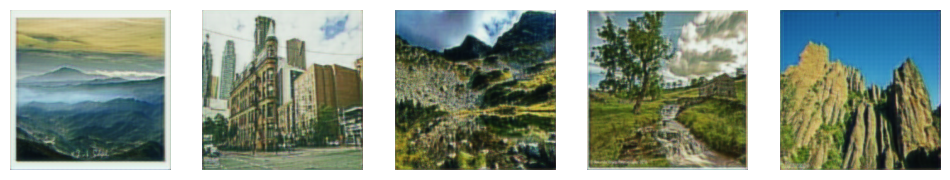

Epoch 11/20, Gen G Loss: 2.1431798934936523, Gen F Loss: 1.9799869060516357, Disc Monet Loss: 0.21799933910369873, Disc Photo Loss: 0.20640206336975098
Epoch 12/20, Gen G Loss: 2.2751762866973877, Gen F Loss: 2.5548160076141357, Disc Monet Loss: 0.2669891119003296, Disc Photo Loss: 0.28767240047454834
Epoch 13/20, Gen G Loss: 2.641313314437866, Gen F Loss: 3.1919448375701904, Disc Monet Loss: 0.21998707950115204, Disc Photo Loss: 0.2631765305995941
Epoch 14/20, Gen G Loss: 2.7560739517211914, Gen F Loss: 2.2282299995422363, Disc Monet Loss: 0.1397891640663147, Disc Photo Loss: 0.165854349732399
Epoch 15/20, Gen G Loss: 2.177037000656128, Gen F Loss: 1.7542674541473389, Disc Monet Loss: 0.1808151751756668, Disc Photo Loss: 0.21760514378547668
Epoch 16/20, Gen G Loss: 1.9229416847229004, Gen F Loss: 2.0439836978912354, Disc Monet Loss: 0.19932803511619568, Disc Photo Loss: 0.19951392710208893
Epoch 17/20, Gen G Loss: 2.3130545616149902, Gen F Loss: 1.7526320219039917, Disc Monet Loss: 0.

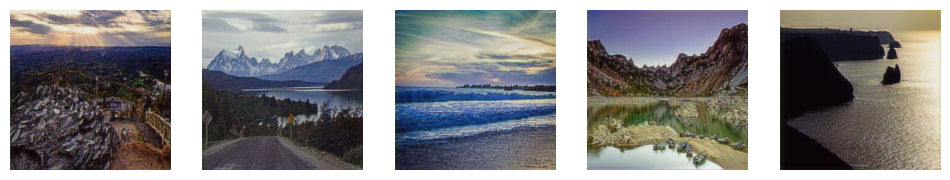

In [11]:
# Define and build the models
G = build_generator()  # Generator for Photo -> Monet
F = build_generator()  # Generator for Monet -> Photo
D_Monet = build_discriminator()  # Discriminator for Monet images
D_Photo = build_discriminator()  # Discriminator for Photo images

# Define separate optimizers for each generator and discriminator
generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_monet_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_photo_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Initialize lists to store losses for plotting
gen_g_losses = []
gen_f_losses = []
disc_monet_losses = []
disc_photo_losses = []

# Run the training
epochs = 20

for epoch in range(epochs):
    for real_photo, real_monet in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
        gen_g_loss, gen_f_loss, disc_monet_loss, disc_photo_loss = train_step(real_photo, real_monet)

    # Append losses for plotting
    gen_g_losses.append(gen_g_loss.numpy())
    gen_f_losses.append(gen_f_loss.numpy())
    disc_monet_losses.append(disc_monet_loss.numpy())
    disc_photo_losses.append(disc_photo_loss.numpy())

    # Print losses for this epoch
    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Gen G Loss: {gen_g_loss.numpy()}, Gen F Loss: {gen_f_loss.numpy()}, "
          f"Disc Monet Loss: {disc_monet_loss.numpy()}, Disc Photo Loss: {disc_photo_loss.numpy()}")

    # Generate and display sample images every 10 epochs
    if (epoch + 1) % 10 == 0:
        sample_images(generator=G, epoch=epoch + 1)


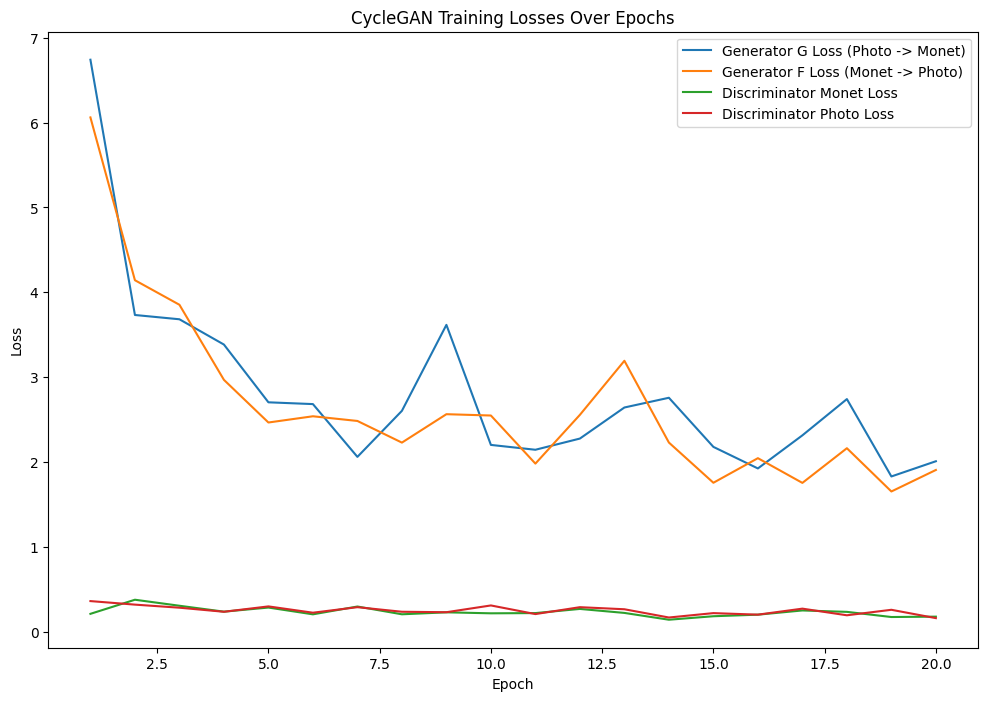

In [12]:
# Plot the recorded losses
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs_range, gen_g_losses, label="Generator G Loss (Photo -> Monet)")
plt.plot(epochs_range, gen_f_losses, label="Generator F Loss (Monet -> Photo)")
plt.plot(epochs_range, disc_monet_losses, label="Discriminator Monet Loss")
plt.plot(epochs_range, disc_photo_losses, label="Discriminator Photo Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CycleGAN Training Losses Over Epochs")
plt.show()

## Results and Analysis

The CycleGAN model was trained over 20 epochs to transform real-world photos into Monet-style paintings. 

### Results

The loss graphs above illustrate the model's performance over 20 epochs, showing the evolution of the generator and discriminator losses. Additionally, the generated images demonstrate the model's ability to approximate Monet's artistic style while maintaining structural coherence.

- **Loss Graphs**: As shown in the plot, the generator losses (`Gen G Loss` and `Gen F Loss`) initially decreased significantly, then fluctuated around a stable range after approximately 10-15 epochs. This suggests that the model found a balance where it can generate images resembling Monet's style without drastic shifts.
- **Generated Images**: Sample images generated after 20 epochs show that the model has successfully learned Monet-like colors, textures, and brushstroke patterns. However, some generated images still lack certain nuanced details, indicating room for improvement in style fidelity.

### Hyperparameter Optimization

Several hyperparameters were optimized to enhance the model's stability and the quality of generated images:
- **Learning Rate**: Initially set to 0.0002 for both the generators and discriminators. This moderate learning rate helped maintain stable training without causing large fluctuations in the loss values.
- **Cycle and Identity Loss Weights**: The weights for cycle consistency loss and identity loss were set to 10 and 5, respectively. These weights provided a balance between maintaining content structure and achieving style transfer. Increasing these values led to an overemphasis on content preservation, while lower values caused a loss of structure.
- **Batch Size**: Reduced to 8 due to memory constraints. This change also contributed to stable training and allowed the model to converge effectively.

### Analysis of Model Performance

- **Why Certain Settings Worked**:
  - **Cycle Consistency**: The high weight on cycle consistency loss helped maintain the core content and structure of the images. This resulted in Monet-style images that still retained the original photo content.
  - **Layer Normalization**: Using Layer Normalization over Instance Normalization helped to maintain the color balance in the generated images, aligning with Monet's style while avoiding extreme color shifts.
  - **Residual Blocks**: The residual blocks in the generator allowed the model to learn complex textures and brushstrokes, essential for capturing Monet's unique artistic style.

- **Troubleshooting Steps**:
  - **Memory Constraints**: The batch size was reduced from 32 to 8 due to resource limitations. This adjustment helped to prevent out-of-memory errors and allowed for smoother training.
  - **Training Instability**: During early trials, the model experienced fluctuations in loss values. Adjusting the learning rate and loss weights helped to stabilize the training process.


# Conclusion

This project successfully demonstrated the potential of CycleGANs for unpaired image-to-image translation, specifically for transforming real-world photos into Monet-style paintings. Through careful tuning of hyperparameters and model architecture, the model could learn Monet’s characteristic style, including color palettes, textures, and brushstroke patterns, while retaining the core content of the original photos.

### Takeaways

- **Cycle Consistency and Identity Losses**: These two losses played a crucial role in preserving the structure and content of the photos during the transformation. This balance between style transfer and content preservation was critical for achieving realistic results.
- **Importance of Normalization and Residual Blocks**: Layer Normalization helped maintain color consistency. In contrast, residual blocks allowed the model to capture more complex textures, enhancing the Monet-like quality of the generated images.

### Challenges and Limitations

- **Training Stability**: GANs are inherently unstable, and early trials exhibited fluctuations in loss values. Adjustments to the learning rate and loss weights were necessary to stabilize the model, but further tuning could be beneficial.
- **Memory Constraints**: The batch size was reduced due to limited resources, potentially impacting the convergence rate. Training with higher-resolution images or a larger dataset might yield better results but requires more computational resources.

### Improvements

- **Extended Training**: Increasing the number of epochs could allow the model to refine its transformations further and capture additional artistic nuances.
- **Alternative Architectures**: Experimenting with other architectures, such as adding more residual blocks or exploring advanced GAN variations (e.g., StyleGAN), could enhance the model’s ability to mimic Monet’s style.
- **Data Augmentation**: Incorporating data augmentation techniques could improve model robustness, allowing it to generalize better and potentially produce higher-quality transformations.




In [13]:
import tensorflow as tf
import os
import zipfile
from tqdm import tqdm
# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1000  # Number of images generated per batch
NUM_IMAGES = 7000
output_dir = "/kaggle/working/images"
os.makedirs(output_dir, exist_ok=True)
# Function to generate a batch of images and save them
def generate_images_batch(generator, start_idx, num_images=BATCH_SIZE, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    for i in range(start_idx, start_idx + num_images):
        try:
            # Generate random noise as input and create an image
            random_photo = tf.random.normal([1, img_height, img_width, 3])
            generated_image = generator(random_photo, training=False)[0]
            generated_image = (generated_image + 1) * 127.5
            generated_image = tf.cast(generated_image, tf.uint8)
            
            # Save the generated image
            img_path = os.path.join(output_dir, f"image_{i+1}.jpg")
            tf.keras.preprocessing.image.save_img(img_path, generated_image)
        
        except Exception as e:
            print(f"Error generating image {i+1}: {e}")
            continue  # Skip and move to the next image if error occurs
    # Clear memory after each batch
    tf.keras.backend.clear_session()
# Generate images in batches and handle potential errors
for batch_start in range(0, NUM_IMAGES, BATCH_SIZE):
    print(f"Generating batch starting from image {batch_start + 1}")
    generate_images_batch(G, batch_start)
# Create zip file for submission
def create_submission_zip(output_dir, zip_filename="images.zip"):
    with zipfile.ZipFile(zip_filename, "w") as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                zipf.write(os.path.join(root, file), arcname=file)
create_submission_zip(output_dir)
print("Submission file 'images.zip' created successfully.")


Generating batch starting from image 1
Generating batch starting from image 1001
Generating batch starting from image 2001
Generating batch starting from image 3001
Generating batch starting from image 4001
Generating batch starting from image 5001
Generating batch starting from image 6001
Submission file 'images.zip' created successfully.
